### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [3]:
# import required libraries
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

In [4]:
#!pip install tqdm

## Support functions and variables

In [5]:
#!unzip ml-100k.zip -d .

In [6]:
MOVIELENS_DIR = "ml-100k"

In [7]:
!ls {MOVIELENS_DIR}

README
allbut.pl
mku.sh
u.data
u.genre
u.info
u.item
u.occupation
u.user
u1.base
u1.test
u2.base
u2.test
u3.base
u3.test
u4.base
u4.test
u5.base
u5.test
ua.base
ua.test
ub.base
ub.test


In [8]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [9]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [10]:
#rating_df

In [11]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [12]:
def dataPreprocessor(rating_df, num_users, num_items):

    # Initializing a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populating the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    

    return matrix

In [13]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [14]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):

        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):

        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
   
        predictionMatrix = np.zeros((num_users, num_items))

        for (user,item), rating in np.ndenumerate(train_matrix):


            userVector = train_matrix[user, :]
            ratedItems = userVector[userVector.nonzero()]


            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg


            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):


        predictionMatrix = np.zeros((num_users, num_items))


        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            #if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

                
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):

        return self.__model
    
    def getPredColName(self):

        return self.pred_column_name
    
    def reset(self):

        try:
            self.model = None
        except:
            print("You don not have this model..")
            

In [15]:
popularity_recsys = BaseLineRecSys('popularity')

In [16]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [17]:
x = popularity_recsys.getModel()

In [18]:
np.all(x<=1)

True

In [19]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [20]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:54, 875.20it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [21]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [22]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [23]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [24]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:40, 996.65it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [25]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):

        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):

        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):

        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):

        similarity_matrix = 1 /(1 + pairwise_distances(matrix, metric='euclidean'))

        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
    
        similarity_matrix = 1 /(1 + pairwise_distances(matrix, metric='manhattan'))
    
   
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':

            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
    #         if k is not None:
    #             uu_similarity = kNearestNeighbor(uu_similarity, k)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            
            
            normatempsum = np.sum(temp_matrix, axis=1)
            normatempsum[normatempsum == 0] = 1e-5
            useraverage = np.sum(train_matrix, axis=1)/normatempsum
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

            self.__model = predictionMatrix  

            
        elif self.base == 'item':
            
            train_matrix = train_matrix.transpose()    

            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
    #         if k is not None:
    #             uu_similarity = kNearestNeighbor(uu_similarity, k)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            
            
            normatempsum = np.sum(temp_matrix, axis=1)
            normatempsum[normatempsum == 0] = 1e-5
            useraverage = np.sum(train_matrix, axis=1)/normatempsum
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

            self.__model = predictionMatrix.transpose()
            
          
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):

        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        return self.__model
    
    def getPredColName(self):

        return self.pred_column_name
    
    def reset(self):

        try:
            self.model = None
        except:
            print("You do not have model..")

In [26]:
# # Examples of how to call similarity functions.
# I = [[1,1],[5,5]]
# SimBasedRecSys.cosine(I)

In [27]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [28]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [29]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

## Analysis

Cosine works better than Euclidean mainly due to length normalization.

But in our case we also normalized values of Euclidean so both are having overlap in confidence intervals for RMSE. 

For example If I have two users who rated (4,4) and (5,5) two movies they can still be similar because each user has different relative perspectives both of them didnt hate the movie. So in this case cosine works better than Euclidean

For example If I have two user who rated (1,1) and (5,5) two movies. Cosine says they are similar but clearly they are not. 

From our results in Q4 

'user-euclidean': [[1.0319953645887305,
  1.013706565892023,
  1.031268958300787],
 'item-euclidean': [[1.0452460304884215,
  1.0157114777932958,
  1.0413212192481176]}

 'user-cosine': [[1.026449013124381,
   1.009013080226148,
  1.0256951630950135],
  'item-cosine': [[1.0377631264364244,
   1.0068242686250732,
   1.0333415315874226]}

### (b)

Manhattan is choosen because it calculates the distance of two vectors by absolute differences. It is similar to Euclidean because we are normalizing both of them (similar results checked in bottom). In case of manhattan it is more robust and it requires less calculations.

## Q3

### (a)

In [30]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [31]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [32]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [33]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [34]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [35]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:42, 971.41it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


### (b)

In [36]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):

        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):

        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):

        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):

        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):

        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):

        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):

        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [38]:

algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys]

In [39]:

cv_patk = CrossValidation('RMSE')

In [40]:

cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1233.36it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1300.91it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1267.19it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:20, 999.46it/s] 


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1148.04it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1358.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1326.62it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1277.72it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1332.99it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1352.55it/s]


Processing algorithm user-cosine


20000it [00:15, 1310.28it/s]
20000it [00:18, 1109.45it/s]
20000it [00:14, 1378.07it/s]
20000it [00:14, 1366.68it/s]
20000it [00:16, 1230.16it/s]


Processing algorithm item-cosine


20000it [00:17, 1130.71it/s]
20000it [00:14, 1353.55it/s]
20000it [00:14, 1364.26it/s]
20000it [00:14, 1369.67it/s]
20000it [00:15, 1331.38it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [41]:
q3df = dataPreprocessor(rating_df, num_users, num_items)

In [42]:
#q3df 

In [43]:
temp_matrix = np.zeros(q3df.shape)
temp_matrix[q3df.nonzero()] = 1 
sumperrow = np.sum(temp_matrix, axis=1)
averagenumberofratingsperuser = (sumperrow.sum())/943
averagenumberofratingsperitem = (sumperrow.sum())/1682

In [44]:
averagenumberofratingsperitem

59.45303210463734

In [45]:
averagenumberofratingsperuser

106.04453870625663

## 3b) Analysis

The following values are RMSE average, low CI and high CI

'item-cosine': [
  1.020,
  1.006,
  1.033,

 'user-cosine': [
  1.017,
  1.009,
  1.025,
  
  
If we see the RMSE results the user user is performing slightly better because in our case the average number of ratings per user 106 is more than the average number of ratings per item 59. So while using similarity metrics in case of users we have more rich vectors to find out the similar ones. so better predictions.


 


## Q4

### (a)

In [46]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [47]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [48]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys]

In [49]:
cv_patk = CrossValidation('RMSE')

In [50]:
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1356.30it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1347.44it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1361.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1374.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1365.47it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1293.49it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:16, 1213.67it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1299.97it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1357.05it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1158.76it/s]


Processing algorithm user-cosine


20000it [00:15, 1269.45it/s]
20000it [00:13, 1490.43it/s]
20000it [00:17, 1118.64it/s]
20000it [00:17, 1175.65it/s]
20000it [00:20, 999.11it/s]


Processing algorithm item-cosine


20000it [00:16, 1189.63it/s]
20000it [00:16, 1194.11it/s]
20000it [00:17, 1168.30it/s]
20000it [00:14, 1336.55it/s]
20000it [00:19, 1046.58it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [51]:
cv_patk = CrossValidation('P@K')

In [52]:
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1287.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1343.37it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1123.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:18, 1079.10it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1121.33it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:17, 1122.59it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1360.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1309.17it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1292.78it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1379.02it/s]


Processing algorithm user-cosine


20000it [00:14, 1341.75it/s]
20000it [00:14, 1377.50it/s]
20000it [00:14, 1371.46it/s]
20000it [00:14, 1379.98it/s]
20000it [00:14, 1369.02it/s]


Processing algorithm item-cosine


20000it [00:14, 1356.02it/s]
20000it [00:18, 1099.87it/s]
20000it [00:16, 1215.29it/s]
20000it [00:14, 1376.84it/s]
20000it [00:16, 1246.42it/s]


{'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [53]:
cv_patk = CrossValidation('R@K')

In [54]:
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:18, 1110.60it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1389.18it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1384.37it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1293.74it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:18, 1097.94it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1308.39it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1347.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1302.25it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:14, 1369.49it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:15, 1273.16it/s]


Processing algorithm user-cosine


20000it [00:15, 1306.42it/s]
20000it [00:18, 1106.38it/s]
20000it [00:17, 1155.94it/s]
20000it [00:19, 1035.46it/s]
20000it [00:18, 1055.35it/s]


Processing algorithm item-cosine


20000it [00:17, 1156.54it/s]
20000it [00:16, 1225.11it/s]
20000it [00:17, 1120.76it/s]
20000it [00:16, 1243.78it/s]
20000it [00:18, 1069.23it/s]


{'item-cosine': [[0.3277711938444533,
   0.4237782250680911,
   0.5191391022223312,
   0.5448659224612776,
   0.5593011306991799],
  0.4749711148590666,
  0.35357317503649865,
  0.5963690546816346],
 'popularity': [[0.3466588624187514,
   0.4274468698270901,
   0.5269205125667804,
   0.5518738761026849,
   0.5674793185065369],
  0.4840758878843688,
  0.3671373629798323,
  0.6010144127889052],
 'user-cosine': [[0.34778041993806913,
   0.4314035774468209,
   0.5293633772333985,
   0.5553818201403046,
   0.5674144230096255],
  0.4862687235536437,
  0.3694473610987218,
  0.6030900860085656],
 'useraverage': [[0.30505841002027845,
   0.39554692074366876,
   0.48030412192442223,
   0.5045885853815734,
   0.5211179870422066],
  0.44132320502242983,
  0.32931026359142457,
  0.5533361464534351]}

## Q4a) Analysis

For each of the metrics the three values are Average, Low CI and high CI.

                 Ave LowCI HIgh CI
RMSE
{'item-cosine': [
1.020,
1.006,
1.033,

 'popularity': [
  3.159,
  3.139,
  3.178,
  
 'user-cosine': [
  1.017,
  1.009,
  1.025,
  
 'useraverage': [
  1.043,
  1.028,
  1.058,}
  
  
P@K  
  {'item-cosine': [
  0.532,
  0.383,
  0.680,
  
 'popularity': [
  0.550,
  0.405,
  0.695,
  
 'user-cosine': [
  0.555,
  0.409,
  0.702,
  
 'useraverage': [
  0.473,
  0.341,
  0.605]}
  
  
R@K

{'item-cosine': [
  0.474,
  0.353,
  0.596],
  
 'popularity': [
  0.484,
  0.367,
  0.601,
  
 'user-cosine': [
  0.486,
  0.369,
  0.603,
  
 'useraverage': [
  0.441,
  0.329,
  0.553}

## (b)
Some baselines cannot be evaluated with some metrics? Which ones and why?

For User Average

This predicts the same average rating for all the movies for a user (for the movies there are no ratings). In this case rank based metrics P@k and R@k cannot be evaluated

For popularity

We cannot use RMSE for popularity becuase the popularity values in this case are between 0 to 1 (because we are not taking the exact rating for calculation we have only taken if the user liked(rating > 4) or not) but the test ratings are from 1 to 5. so RMSE cannot be evaluated



## (C)

What is the best algorithm for each of RMSE, P@k, and R@k?  Can you explain why this
may be?

P@k and R@k the evaluations are based on ranking (we need to recommend most relavant to each user). For better ranking the similarity metrics are most suitable because the popularity and average are not persnolized to each user. From the results we can say that user cosine average performed slighlty better in both P@K and R@K.

For RMSE cosine similarity measures work better becuase the similarity measures predict the rating based on ratings of most similar users or items. We can also see that in case of RMSE similarity measure have better performed.

## (D)

Does good performance on RMSE imply good performance on ranking metrics and vice versa?
Why / why not?

No good performance of RMSE doesn't imply good performace on ranking metrics. Becuase RMSE is calulated for all the user ratings wheter he liked it or not irrespective of their rankings. So good RMSE may come at expense of bad ranking of top K.

Similarly, in case of ranking metrics we are only concerned about ranking in top k and have no clue about others. So good performance of ranking doesn't necasarily mean good performance of RMSE.


In [55]:
# calculating Eculidean to know which is better
item_cosine_recsys = SimBasedRecSys('item','euclidean')

In [56]:
user_cosine_recsys = SimBasedRecSys('user','euclidean')

In [57]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

In [58]:
cv_patk = CrossValidation('RMSE')

In [59]:
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-euclidean


20000it [00:15, 1276.24it/s]
20000it [00:14, 1367.99it/s]
20000it [00:18, 1104.85it/s]
20000it [00:15, 1273.15it/s]
20000it [00:14, 1383.41it/s]


Processing algorithm item-euclidean


20000it [00:17, 1116.88it/s]
20000it [00:16, 1189.77it/s]
20000it [00:15, 1324.50it/s]
20000it [00:18, 1056.24it/s]
20000it [00:19, 1036.38it/s]


{'item-euclidean': [[1.0452460304884215,
   1.0315283051917867,
   1.0203644555365832,
   1.0215306724762894,
   1.023912278910453],
  1.0285163485207067,
  1.0157114777932958,
  1.0413212192481176],
 'user-euclidean': [[1.0319953645887305,
   1.0272960502657182,
   1.017739206917733,
   1.0146850193650487,
   1.0207231693447965],
  1.0224877620964052,
  1.0137065658920232,
  1.0312689583007872]}

'user-cosine': [
  1.017,
  1.009,
  1.025],
'item-cosine': [
  1.020,
  1.006,
  1.033]}
  
'item-euclidean': [
  1.028,
  1.015,
  1.041],
'user-euclidean': [
  1.022,
  1.013,
  1.031]
  }
  
Overlapping intervals

manhattan

In [60]:
user_cosine_recsys = SimBasedRecSys('user','euclidean')
item_cosine_recsys = SimBasedRecSys('item','euclidean')

In [61]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

In [62]:
cv_patk = CrossValidation('RMSE')

In [63]:
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-euclidean


20000it [00:14, 1342.10it/s]
20000it [00:14, 1374.00it/s]
20000it [00:14, 1374.57it/s]
20000it [00:16, 1235.25it/s]
20000it [00:15, 1330.18it/s]


Processing algorithm item-euclidean


20000it [00:16, 1187.65it/s]
20000it [00:18, 1087.31it/s]
20000it [00:14, 1382.46it/s]
20000it [00:14, 1374.66it/s]
20000it [00:14, 1371.01it/s]


{'item-euclidean': [[1.0452460304884215,
   1.0315283051917867,
   1.0203644555365832,
   1.0215306724762894,
   1.023912278910453],
  1.0285163485207067,
  1.0157114777932958,
  1.0413212192481176],
 'user-euclidean': [[1.0319953645887305,
   1.0272960502657182,
   1.017739206917733,
   1.0146850193650487,
   1.0207231693447965],
  1.0224877620964052,
  1.0137065658920232,
  1.0312689583007872]}

'user-euclidean': [

  1.022487762096405,
  1.013706565892023,
  1.031268958300787],
  
  
 'item-euclidean': [
 
  1.0285163485207067,
  1.0157114777932958,
  1.0413212192481176]}
  
  
  {'item-mahattan': 
  1.0285163485207067,
  1.0157114777932958,
  1.0413212192481176],
  
  
 'user-manhattan': 
  1.0224877620964052,
  1.0137065658920232,
  1.0312689583007872]}

## Q5

### (a)

In [64]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [65]:
q5df = dataPreprocessor(rating_df, num_users, num_items)

In [66]:
q5df

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [67]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')


In [68]:
moviesDF[1100:1300]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
1100,1101,Six Degrees of Separation (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Six%20Degrees...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1101,1102,Two Much (1996),01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Two%20Much%20...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1102,1103,Trust (1990),01-Jan-1990,NaN,http://us.imdb.com/Title?Trust+(1990),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1103,1104,C'est arrivé près de chez vous (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?C%27est%20arr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1104,1105,Firestorm (1998),09-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1105,1106,"Newton Boys, The (1998)",14-Mar-1998,NaN,"http://us.imdb.com/Title?Newton+Boys,+The+(1998)",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1106,1107,Beyond Rangoon (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Beyond%20Rang...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1107,1108,Feast of July (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Feast%20of%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,1109,Death and the Maiden (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Death%20and%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1109,1110,Tank Girl (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Tank%20Girl%2...,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [69]:
# 110	Operation Dumbo Drop (1995)
# 224	Ridicule (1996)
# 527	Gandhi (1982)
# 874	Career Girls (1997)
# 1299	Penny Serenade (1941)

In [70]:
listindex = [109,223,526,873,1298]

In [71]:
listmovieid = [110,224,527,874,1299]

In [72]:
trainSet = q5df
trainSet = trainSet.transpose()  
uu_similarity = 1 - pairwise_distances(trainSet, metric='cosine')

In [73]:
uu_similarity

array([[1.        , 0.40238218, 0.33024479, ..., 0.        , 0.04718307,
        0.04718307],
       [0.40238218, 1.        , 0.27306918, ..., 0.        , 0.07829936,
        0.07829936],
       [0.33024479, 0.27306918, 1.        , ..., 0.        , 0.        ,
        0.09687505],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.09687505, ..., 0.        , 0.        ,
        1.        ]])

In [74]:
final = np.argsort(uu_similarity, axis=1, kind='quicksort', order=None)[:,1676:1682]

In [75]:
final

array([[ 404,  116,  120,  180,   49,    0],
       [  61,  402,  384,  160,  232,    1],
       [ 249,   32,   41,  762,  409,    2],
       ...,
       [ 909, 1430, 1394, 1677, 1678, 1679],
       [1405, 1422, 1621, 1350, 1671, 1680],
       [ 556,  592, 1596, 1334,  766, 1681]], dtype=int64)

In [76]:
listmovieid = [110,224,527,874,1299]

In [77]:
listindex = [109,223,526,873,1298]

In [78]:
moviesDF.iloc[109,1]

'Operation Dumbo Drop (1995)'

In [117]:
for i in listindex:
    movielist = final[i]
    print("Top similar movies to")
    print(moviesDF.iloc[i,1])
    print("are")

    for j in movielist:
        print(moviesDF.iloc[j,1])
    print("\n")

    

Top similar movies to
Operation Dumbo Drop (1995)
are
Corrina, Corrina (1994)
Made in America (1993)
Santa Clause, The (1994)
Angels in the Outfield (1994)
Junior (1994)
Operation Dumbo Drop (1995)


Top similar movies to
Ridicule (1996)
are
Looking for Richard (1996)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)
Big Night (1996)
Little Odessa (1994)
Cold Comfort Farm (1995)
Ridicule (1996)


Top similar movies to
Gandhi (1982)
are
Casablanca (1942)
Raiders of the Lost Ark (1981)
Forrest Gump (1994)
One Flew Over the Cuckoo's Nest (1975)
Amadeus (1984)
Gandhi (1982)


Top similar movies to
Career Girls (1997)
are
In the Company of Men (1997)
Ice Storm, The (1997)
Ulee's Gold (1997)
Kicked in the Head (1997)
Steel (1997)
Career Girls (1997)


Top similar movies to
Penny Serenade (1941)
are
Love in the Afternoon (1957)
Laura (1944)
Band Wagon, The (1953)
Gay Divorcee, The (1934)
Charade (1963)
Penny Serenade (1941)




### (b)

If group of items are similar it means their item vectors are similar. This happens when same user ranked all of the items. 

In this case the magnitude of their rating doesn't matter becuase we are using cosine metric. only thing which matters if the same users have rated the items or not. For this to happen there could be many reasons like all the movies belonging to a particular genre or all of them have same actor, genre or director. 

Justify

Top similar movies to
Career Girls (1997)

are
In the Company of Men (1997)

Ice Storm, The (1997)

Ulee's Gold (1997)

Kicked in the Head (1997)

Steel (1997)

Career Girls (1997)

All of them have same genre "DRAMA" and all of them are released in same year. In fact the movies all released in same year. So DRAMA lovers of 1990's must have rated all the movies.



## Q6 [GRAD ONLY]

### (a)

In [80]:
q6df = dataPreprocessor(rating_df, num_users, num_items)

In [81]:
#q6df.shape

In [82]:
#q6df

In [83]:
temp_matrix = np.zeros(q6df.shape)
temp_matrix[q6df.nonzero()] = 1 
userratingsnumber = np.sum(temp_matrix, axis=1)

In [84]:
#userratingsnumber.shape

In [85]:
import matplotlib.pyplot as plt

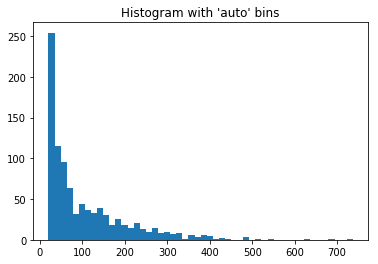

In [86]:
plt.hist(userratingsnumber, bins=50)
plt.title("Histogram with 'auto' bins")
plt.show()

In [87]:
#userratingsnumber

In [88]:
type(userratingsnumber)

numpy.ndarray

In [89]:
np.percentile(userratingsnumber,75)

148.0

In [90]:
thresholdbelow = np.argwhere(userratingsnumber <= 148).flatten()

In [91]:
len(thresholdbelow)

709

In [92]:
thresholdabove = np.argwhere(userratingsnumber > 148).flatten()

In [93]:
len(thresholdabove)

234

In [94]:
class CrossValidationq6above(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):

        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):

        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):

        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):

        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):

        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):

        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            train_set = train_set.loc[train_set['userID'].isin(thresholdabove)]
            
            test_set = getData(data_path, data_types[1].format(i))
            test_set = test_set.loc[test_set['userID'].isin(thresholdabove)]
            
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):

        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [95]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [96]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [97]:
# 1. gather your algorithms in previous steps.
algorithm_instances_Q6 = [user_cosine_recsys,
                          item_cosine_recsys]

In [98]:
cv_patk = CrossValidationq6above('RMSE')
cv_patk.run(algorithm_instances_Q6, num_users, num_items)

Processing algorithm user-cosine


5690it [00:03, 1487.19it/s]
5970it [00:04, 1487.67it/s]
5067it [00:03, 1387.46it/s]
4833it [00:03, 1463.66it/s]
4869it [00:03, 1496.31it/s]


Processing algorithm item-cosine


5690it [00:03, 1489.14it/s]
5970it [00:04, 1407.69it/s]
5067it [00:03, 1403.21it/s]
4833it [00:03, 1411.92it/s]
4869it [00:03, 1466.56it/s]


{'item-cosine': [[1.0568322167581496,
   1.058552860154752,
   1.0251820359216575,
   1.0437442042286282,
   1.0722515432038346],
  1.0513125720534044,
  1.029262861402853,
  1.073362282703956],
 'user-cosine': [[1.0503720301028903,
   1.0760128059562617,
   1.0570055555699578,
   1.054340869987063,
   1.0468077895648276],
  1.0569078102362,
  1.042800757991966,
  1.0710148624804339]}

In [99]:
#   1.0168410913473036,
#    1.0147096245053064],

In [100]:
class CrossValidationq6below(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):

        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):

        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):

        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):

        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):

        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):

        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            train_set = train_set.loc[train_set['userID'].isin(thresholdbelow)]
            
            test_set = getData(data_path, data_types[1].format(i))
            test_set = test_set.loc[test_set['userID'].isin(thresholdbelow)]
            
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):

        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [101]:
cv_patk = CrossValidationq6below('RMSE')
cv_patk.run(algorithm_instances_Q6, num_users, num_items,k=5)

Processing algorithm user-cosine


14310it [00:11, 1260.68it/s]
14030it [00:10, 1306.33it/s]
14933it [00:11, 1284.56it/s]
15120it [00:11, 1295.96it/s]
15010it [00:12, 1245.95it/s]


Processing algorithm item-cosine


14310it [00:10, 1351.02it/s]
14030it [00:09, 1414.46it/s]
14933it [00:12, 1178.71it/s]
15120it [00:12, 1165.51it/s]
15010it [00:13, 1120.57it/s]


{'item-cosine': [[1.0462718991797464,
   1.02116589621018,
   1.0146139914163754,
   1.016889536902209,
   1.0147096245053064],
  1.0227301896427634,
  1.0060602497033544,
  1.0394001295821724],
 'user-cosine': [[1.0292964812509109,
   1.0134988342423394,
   1.0162441815962555,
   1.0083129744573012,
   1.0168529851897112],
  1.0168410913473036,
  1.0072353809052537,
  1.0264468017893535]}

## Q6

For each metric the ave, low cI and high cI are considered

Below are the values thes are

{'item-cosine': [
  1.022,
  1.006,
  1.039,
  
 'user-cosine': [
  1.016,
  1.007,
  1.026}
  
Above

{'item-cosine': [
  1.051,
  1.029,
  1.073,
  
 'user-cosine': [
  1.056,
  1.042,
  1.071]}


Full members
{'item-cosine': 
[ 1.020,
1.006, 
1.033,


'user-cosine': 
[ 1.017,
1.009, 
1.025,

  
The RMSE values of below are less than Above. so the below perfomed better becuase in case for below we have more points (can see the number of iterations) and more vectors so better predictions. In the same way for full members as it has more information than either of the cases it performed slightly better. 

But the above analysis cannot be generalized unless I see the other k values. Even I am changing the K values by 10 there is more diffence. There is tradeoof between number of vectors and number of ratings inside a vector